In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, feature
from scipy.stats import entropy
from itertools import chain
import cv2

## Parámetros

In [277]:
# distancia de comparación entre pixeles
distancia = 2
# tamaño de la ventana
n = 5
# angulo de comparaciones
angulo = [0, 45, 90]
# blur
blur = 21

## Funciones para generar los datos de prueba

In [278]:
def GLCM(matriz,distancia,angulo,escala):
  '''
  matriz: matriz inicial
  distancia: distancia de movimiento 
  angulo: ángulo
  escala: tamaño de la matriz de co-ocurrencia
  '''
  glcm = np.zeros((escala,escala))
  width, height = matriz.shape 
  for x in range(width):
    for y in range(height):
      if 0 in angulo:#Dirección 0 °
        if y+distancia < height: # Verificación fuera de límites 
          glcm[matriz[x][y]][matriz[x][y+distancia]] += 1

      if 45 in angulo:
        if (x-distancia) >= 0 and 0 < y-distancia:# Verificación fuera de límites
          glcm[matriz[x][y]][matriz[x-distancia][y-distancia]] += 1
                  
      if 90 in angulo: # Verificación fuera de límites
        if x+distancia < width:
          glcm[matriz[x][y]][matriz[x+distancia][y]] += 1

      if 135 in angulo:
        if (y-distancia) >= 0 and x+distancia < width: # Verificación fuera de límites  
          glcm[matriz[x][y]][matriz[x+distancia][y-distancia]] += 1
    #Verificar si la matriz es simetrica 
  if np.array_equal(glcm, glcm.T):
    glcm=glcm+glcm.T

  return vectorizar(glcm.astype("int32"))

In [279]:
def vectorizar(glcm):
  '''Toma una matriz y genera el vector que describe a esa matriz'''
  var = glcm.var()
  mean = glcm.mean()
  std = glcm.std()

  glcm_h = glcm.reshape((-1,1))
  h = entropy(glcm_h, base=2)

  return [mean, var, std, h[0]]

### Funciones para generar los datos (average)

In [280]:
def generar_pruebas_rgb_avg(imagen, distancia, tamaño_x, tamaño_y=None, n=None):
  '''Genera las ventanas de pixeles. Se generan ventanas interpoladas a la mitad
  Parámetros
  imagen: Matriz de la imágen
  distancia: Distancia de comparación entre pixeles
  tamaño_x: tamaño de la imágen en X
  tamaño_y: tamaño de la imágen en Y
  n: tamaño de la ventana
  '''
  if n==None:
    n = distancia*2+1

  if tamaño_y==None:
    tamaño_y=tamaño_x
  
  ventanas = list()

  for i in range(0,tamaño_x-n,n//2):
    for j in range(0,tamaño_y-n,n//2):
      # Genera la ventana
      matriz = imagen[i:i+n,j:j+n,:] # 5x5x3 75 
      # Encontramos la suma de la matriz ponderada
      suma = np.sum(matriz)
      # Si la ponderación es diferente a 0, se agrega
      if suma != 0:
        # Genera una matriz ponderando los valores rgb
        avg_rgb = np.round(np.average(matriz, axis=2)).astype("int32")
        
        ventanas.append(avg_rgb)

  return ventanas

def etiquetar(lista_muestras, etiqueta):
  '''Etiqueta un conjunto de muestras'''
  return [(x, etiqueta) for x in lista_muestras]

In [281]:
def sacar_pruebas_avg(url, distancia, n, angulo, etiqueta):
  # cargamos la imágen
  img = cv2.imread(url)
  img = cv2.GaussianBlur(img,(blur,blur),0)

  # establecemos el valor posible de pixeles
  escala = 256

  # Se generan las pruebas
  lista_pruebas = generar_pruebas_rgb_avg(img, distancia, img.shape[0], img.shape[1], n)

  # Generamos las glcm de cada prueba y calculamos los vectores de las pruebas
  lista_pruebas_vectores = [GLCM(ventana, distancia, angulo, escala) for ventana in lista_pruebas]

  # etiquetamos los vectores
  lista_pruebas_vectores_etiquetados = etiquetar(lista_pruebas_vectores, etiqueta)

  return lista_pruebas_vectores_etiquetados

### Funciones para generar los datos (full)

In [342]:
def generar_pruebas_rgb_full(imagen, distancia, angulo, escala, tamaño_x, tamaño_y=None, n=None):
  '''Genera las ventanas de pixeles. Se generan ventanas interpoladas a la mitad
  Parámetros
  imagen: Matriz de la imágen
  distancia: Distancia de comparación entre pixeles
  tamaño_x: tamaño de la imágen en X
  tamaño_y: tamaño de la imágen en Y
  n: tamaño de la ventana
  '''
  if n==None:
    n = distancia*2+1

  if tamaño_y==None:
    tamaño_y=tamaño_x
  
  ventanas = list()

  for i in range(0,tamaño_x-n,distancia):
    for j in range(0,tamaño_y-n,distancia):
      # Genera la ventana
      matriz = imagen[i:i+n,j:j+n,:] # 5x5x3 75
      # Encontramos la suma de la matriz ponderada
      suma = np.sum(matriz)
      # Si la ponderación es diferente a 0, se agrega
      if suma != 0:
        R_GLCM = GLCM(matriz[:,:,0], distancia, angulo, escala)
        G_GLCM = GLCM(matriz[:,:,0], distancia, angulo, escala)
        B_GLCM = GLCM(matriz[:,:,0], distancia, angulo, escala)

        ventanas.append(R_GLCM+G_GLCM+B_GLCM)

  return ventanas

def etiquetar(lista_muestras, etiqueta):
  '''Etiqueta un conjunto de muestras'''
  return [(x, etiqueta) for x in lista_muestras]

In [292]:
def sacar_pruebas_full(url, distancia, n, angulo, etiqueta):
  # cargamos la imágen
  img = cv2.imread(url)
  img = cv2.GaussianBlur(img,(blur,blur),0)

  # establecemos el valor posible de pixeles
  escala = 256

  # Se generan las pruebas
  lista_pruebas_vectores = generar_pruebas_rgb_full(img, distancia, angulo, escala,
                                          img.shape[0], img.shape[1], n)

  # etiquetamos los vectores
  lista_pruebas_vectores_etiquetados = etiquetar(lista_pruebas_vectores, etiqueta)

  return lista_pruebas_vectores_etiquetados

## Generación de datos de prueba (dataset)

In [314]:
# para generar el train-set hay que hacerlo para todas las texturas
texturas_url = [
                #(url, etiqueta)
                ("/content/drive/MyDrive/Aux/Mascaras/img1/P1_Camino.png",0),
                ("/content/drive/MyDrive/Aux/Mascaras/img1/P1_Casas.png",1),
                ("/content/drive/MyDrive/Aux/Mascaras/img1/P1_Vegetación.png",2),
                ("/content/drive/MyDrive/Aux/Mascaras/img2/P2_Camino.png",0),
                ("/content/drive/MyDrive/Aux/Mascaras/img2/P2_Casas.png",1),
                ("/content/drive/MyDrive/Aux/Mascaras/img2/P2_Vegentación.png",2),
                ("/content/drive/MyDrive/Aux/Mascaras/img3/P3_Camino.png",0),
                ("/content/drive/MyDrive/Aux/Mascaras/img3/P3_Casas.png",1),
                ("/content/drive/MyDrive/Aux/Mascaras/img3/P3_Vegetación.png",2),
                ("/content/drive/MyDrive/Aux/Mascaras/img3/P3_Agua.png",3)
                ]

### Average

In [315]:
# dataset para average
train_set_avg = [sacar_pruebas_avg(url,distancia=distancia,n=n,angulo=angulo,etiqueta=etq) for url,etq in texturas_url]

In [316]:
# encadenamos las pruebas para hacer solo una lista average
train_set_new = list()
for lista in train_set_avg:
  train_set_new.extend(lista)
train_set_avg = train_set_new

In [317]:
np.random.shuffle(train_set_avg)

In [318]:
X_avg = np.array([x[0] for x in train_set_avg])
y_avg = np.array([x[1] for x in train_set_avg])

### Full

In [343]:
# dataset para full
train_set_full = [sacar_pruebas_full(url,distancia=distancia,n=n,angulo=angulo,etiqueta=etq) for url,etq in texturas_url]

In [344]:
# encadenamos las pruebas para hacer solo una lista full
train_set_new = list()
for lista in train_set_full:
  train_set_new.extend(lista)
train_set_full = train_set_new

In [345]:
np.random.shuffle(train_set_full)

In [346]:
X_full = np.array([x[0] for x in train_set_full])
y_full = np.array([x[1] for x in train_set_full])

## Entrenamiento con los modelos

In [323]:
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
# Con el clasificador de bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

### Average

#### Clasificador Bayesiano **(Naive Bayes)**

In [324]:
bayes_avg = MultinomialNB()
bayes_avg.fit(X_avg, y_avg)

MultinomialNB()

#### Clasificador K vecinos más cercanos **(K nearest neighbours)**

In [325]:
knn_avg = KNeighborsClassifier(n_neighbors=3)
knn_avg.fit(X_avg, y_avg)

KNeighborsClassifier(n_neighbors=3)

### Full

#### Clasificador Bayesiano **(Naive Bayes)**

In [347]:
bayes_full = MultinomialNB()
bayes_full.fit(X_full, y_full)

MultinomialNB()

#### Clasificador K vecinos más cercanos **(K nearest neighbours)**

In [327]:
knn_full = KNeighborsClassifier(n_neighbors=3)
knn_full.fit(X_full, y_full)

KNeighborsClassifier(n_neighbors=3)

## Prueba

In [302]:
def generar_prediccion_avg(imagen, distancia, tam_x, angulo, escala, clasificador, tam_y=None, n=None):
  '''Genera la imagen predicha

  Parámetros
  imagen: Matriz de la imágen
  distancia: Distancia de comparación entre pixeles
  tam_x: tamaño de la imágen en X
  escala: valor máximo de cada pixel
  clasificador: clasificador 
  tam_y: tamaño de la imágen en Y
  n: tamaño de la ventana
  '''
  if n==None:
    n = distancia*2+1

  if tam_y==None:
    tam_y=tam_x

  nuevaimagen = np.zeros((tam_x, tam_y))

  for i in range(0,tam_x-n,n//2):
    for j in range(0,tam_y-n,n//2):
      # Sacamos la matriz ponderada
      matriz = imagen[i:i+n,j:j+n,:]
      avg_rgb = np.round(np.average(matriz, axis=2)).astype("int32")
      
      Vector_Prediccion=GLCM(avg_rgb, distancia, angulo, escala)

      Solucion=clasificador.predict([Vector_Prediccion])

      nuevaimagen[i:i+n,j:j+n]=85*int(Solucion[0])

  return nuevaimagen

In [348]:
def generar_prediccion_full(imagen, distancia, tam_x, angulo, escala, clasificador, tam_y=None, n=None):
  '''Genera la imagen predicha

  Parámetros
  imagen: Matriz de la imágen
  distancia: Distancia de comparación entre pixeles
  tam_x: tamaño de la imágen en X
  escala: valor máximo de cada pixel
  clasificador: clasificador 
  tam_y: tamaño de la imágen en Y
  n: tamaño de la ventana
  '''
  if n==None:
    n = distancia*2+1

  if tam_y==None:
    tam_y=tam_x

  nuevaimagen = np.zeros((tam_x, tam_y))

  for i in range(0,tam_x-n,distancia):
    for j in range(0,tam_y-n,distancia):
      # Sacamos la matriz ponderada
      matriz = imagen[i:i+n,j:j+n,:]

      R_GLCM = GLCM(matriz[:,:,0], distancia, angulo, escala)
      G_GLCM = GLCM(matriz[:,:,0], distancia, angulo, escala)
      B_GLCM = GLCM(matriz[:,:,0], distancia, angulo, escala)

      Vector_Prediccion = R_GLCM+G_GLCM+B_GLCM

      Solucion=clasificador.predict([Vector_Prediccion])

      nuevaimagen[i:i+n,j:j+n]=85*int(Solucion[0])

  return nuevaimagen

# Resultados

In [328]:
imagen = cv2.imread("/content/drive/MyDrive/Aux/Mascaras/img3/p3.PNG")
imagen = cv2.GaussianBlur(imagen,(blur,blur),0)
imagen2 = cv2.imread("/content/drive/MyDrive/Aux/Mascaras/p4.PNG")
imagen2 = cv2.GaussianBlur(imagen2,(blur,blur),0)
# /content/drive/MyDrive/Aux/Mascaras/p4.PNG

## Average

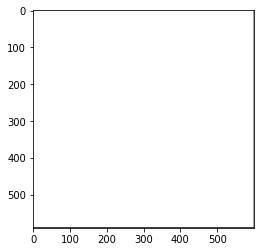

In [329]:
res_avg = generar_prediccion_avg(imagen, distancia=distancia, tam_x=imagen.shape[0], 
                           tam_y=imagen.shape[1], angulo=angulo, escala=escala, 
                           clasificador=bayes_avg, n=n)
plt.imshow(res_avg, cmap="gray")
plt.show()

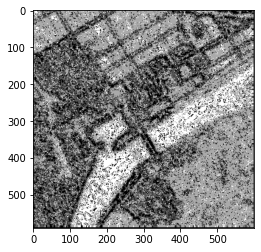

In [330]:
res_avg = generar_prediccion_avg(imagen, distancia=distancia, tam_x=imagen.shape[0], 
                           tam_y=imagen.shape[1], angulo=angulo, escala=escala, 
                           clasificador=knn_avg, n=n)
plt.imshow(res_avg, cmap="gray")
plt.show()

In [ ]:
res_avg = generar_prediccion_avg(imagen2, distancia=distancia, tam_x=imagen2.shape[0], 
                           tam_y=imagen2.shape[1], angulo=angulo, escala=escala, 
                           clasificador=bayes_avg, n=n)
plt.imshow(res_avg, cmap="gray")
plt.show()

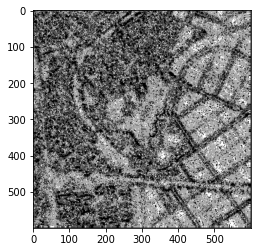

In [332]:
res_avg = generar_prediccion_avg(imagen2, distancia=distancia, tam_x=imagen2.shape[0], 
                           tam_y=imagen2.shape[1], angulo=angulo, escala=escala, 
                           clasificador=knn_avg, n=n)
plt.imshow(res_avg, cmap="gray")
plt.show()

## Full

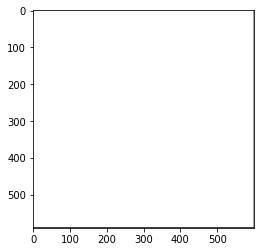

In [351]:
res_full = generar_prediccion_full(imagen, distancia=distancia, tam_x=imagen.shape[0], 
                           tam_y=imagen.shape[1], angulo=angulo, escala=escala, 
                           clasificador=bayes_full, n=n)
plt.imshow(res_full, cmap="gray")
plt.show()

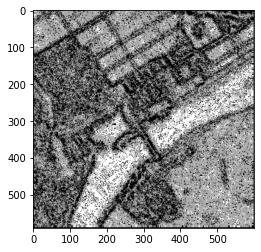

In [334]:
res_full = generar_prediccion_full(imagen, distancia=distancia, tam_x=imagen.shape[0], 
                           tam_y=imagen.shape[1], angulo=angulo, escala=escala, 
                           clasificador=knn_full, n=n)
plt.imshow(res_full, cmap="gray")
plt.show()

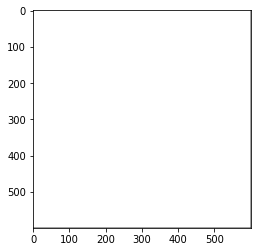

In [335]:
res_full = generar_prediccion_full(imagen2, distancia=distancia, tam_x=imagen2.shape[0], 
                           tam_y=imagen2.shape[1], angulo=angulo, escala=escala, 
                           clasificador=bayes_full, n=n)
plt.imshow(res_full, cmap="gray")
plt.show()

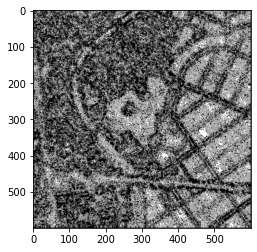

In [336]:
res_full = generar_prediccion_full(imagen2, distancia=distancia, tam_x=imagen2.shape[0], 
                           tam_y=imagen2.shape[1], angulo=angulo, escala=escala, 
                           clasificador=knn_full, n=n)
plt.imshow(res_full, cmap="gray")
plt.show()